# Language Analysis for WikiScraper

In [16]:
import json
import numpy as np
import wordfreq
from wordfreq import top_n_list
from wikiscraper.controller import Controller
from wikiscraper.scraper import Scraper
from wikiscraper.page import Page
from pathlib import Path
from wikiscraper import config

## lang_confidence_score 

In [27]:
def lang_confidence_score(word_counts: dict, language_words_with_frequency: dict) -> float:
    """
    Calculates a confidence score indicating how well the word_counts match a language.
    
    The score is calculated by taking the weighted sum of frequencies of the words 
    present in the text relative to the reference language distribution.
    
    Args:
        word_counts: A dictionary of {word: count} from the source text.
        language_words_with_frequency: A dictionary of {word: frequency} for the target language.
        
    Returns:
        float: A score between 0 and 1, where higher values indicate a better match.
    """
    if not word_counts or not language_words_with_frequency:
        return 0.0

    # Convert counts to relative frequencies (probabilities)
    words = list(word_counts.keys())
    counts = np.array([word_counts[w] for w in words], dtype=float)
    total = counts.sum()
    
    if total == 0:
        return 0.0
    
    text_probs = counts / total

    # Get reference frequencies for the words found in our text
    ref_probs = np.array([language_words_with_frequency.get(w, 0.0) for w in words], dtype=float)

    # Score calculation: Dot product of text distribution and language distribution
    raw_score = np.sum(text_probs * ref_probs)

    # Apply sigmoid-like scaling to normalize the result between 0 and 1
    if raw_score == 0:
        return 0.0
        
    return float(raw_score)


In [41]:
import wordfreq

cl = Controller(clear_json=True)

languages = ['en', 'it', 'da']
k_values = [3, 10, 100, 1000]

lang_refs = {}

for lang in languages:
    full_freq_dict = wordfreq.get_frequency_dict(lang, wordlist='best')
    
    sorted_items = sorted(full_freq_dict.items(), key=lambda x: x[1], reverse=True)
    
    lang_refs[lang] = {}
    
    for k in k_values:
        lang_refs[lang][k] = dict(sorted_items[:k])



In [42]:
print(config.WORD_COUNTS_JSON)

/home/miki/UniProjects/Python/WikiScraper/data/word-counts.json


In [43]:
import json
from pathlib import Path

def get_score_of_page(page: Page, lang: str, k: int = 1000 ) -> float:
    """
    Counts words on a page and calculates its language confidence score
    using the pre-built lang_refs dictionary.
    """
    cl.clear_json()
    page.count_words()

    # Read word counts JSON
    path = Path(config.WORD_COUNTS_JSON)
    raw = path.read_text(encoding="utf-8").strip()
    data = json.loads(raw) if raw else {}

    # Use the global lang_refs for reference frequencies
    return lang_confidence_score(data, lang_refs[lang][k])


def get_worst_page(start_page, lang: str, num: int = 50, k: int = 1000):
    """
    Iterates through pages to find the one that least matches the target language.
    
    Args:
        cl: Controller instance.
        start_page: Initial Page object.
        num: Maximum number of pages to check.
        
    Returns:
        tuple: (worst_page_object, lowest_score)
    """
    curr_page = start_page
    worst_page = start_page
    worst_score = float('inf')

    for _ in range(num):
        score = get_score_of_page(curr_page, lang, k)
        
        if score < worst_score:
            worst_score = score
            worst_page = curr_page
        
        curr_page = cl.next_page(curr_page, wait=0.5)
        if curr_page is None:
            break

    return worst_page, worst_score

## Data Prep

In [34]:
pages = {}

# 1. Get Long Wiki Article (> 5000 words recommended)
long_wiki_page = cl._get_page("Team Rocket") 
pages["long_wiki_page"] = long_wiki_page
print(f"Long Wiki Page loaded: {long_wiki_page.phrase}")

# 2. Find the "Worst" Wiki Page (Minimum score over 50 iterations)
print("Searching for the 'worst' matching Wiki page (this may take a moment)...")
worst_page, worst_score = get_worst_page(long_wiki_page, 'en', num=10)
pages["worst_page"] = worst_page
print(f"Worst Wiki Page found: {worst_page} (Score: {worst_score:.4f})")

# 3. Get Non-Wiki Texts (One for each language)
non_wiki_urls = {
    'en': "https://www.apa.org/monitor/2025/10",
    'it': "https://www.ansa.it/sito/notizie/cultura/cultura.shtml", 
    'da': "https://www.dr.dk/nyheder/viden/klima"
}

for lang, url in non_wiki_urls.items():
    sc = Scraper(wiki_base_url=url)
    pages[f"Non wiki data in {lang}"] = sc.scrape()
    print(f"Scraped non-Wiki text for {lang}")

print("\nData Preparation Complete.")
print(pages)

Long Wiki Page loaded: Team_Rocket
Searching for the 'worst' matching Wiki page (this may take a moment)...
Worst Wiki Page found: <wikiscraper.page.Page object at 0x732781baa210> (Score: 0.0050)
Scraped non-Wiki text for en
Scraped non-Wiki text for it
Scraped non-Wiki text for da

Data Preparation Complete.
{'long_wiki_page': <wikiscraper.page.Page object at 0x7327805ebb90>, 'worst_page': <wikiscraper.page.Page object at 0x732781baa210>, 'Non wiki data in en': <wikiscraper.page.Page object at 0x73277b435010>, 'Non wiki data in it': <wikiscraper.page.Page object at 0x732780c87ef0>, 'Non wiki data in da': <wikiscraper.page.Page object at 0x732780297ef0>}


In [37]:
def compute_scores_table(pages, lang_refs):
    """
    Compute language confidence scores for multiple pages, languages, and k-values.
    
    Returns:
        data: dict[page_name][lang][k] = score
    """
    data = {}

    for page_name, page in pages.items():
        data[page_name] = {}
        for lang in languages:
            data[page_name][lang] = {}
            for k in k_values:
                # Use only top-k words for this language
                score = get_score_of_page(page=page, lang=lang, k=k)
                data[page_name][lang][k] = score

    return data


import matplotlib.pyplot as plt

def plot_scores(data):
    """
    Plot confidence scores for each page over different k-values.
    
    Args:
        data: dict[page_name][lang][k] = score
        languages: list of languages
        k_values: list of k
    """
    for page_name in data:
        plt.figure(figsize=(8, 5))
        for lang in languages:
            scores = [data[page_name][lang][k] for k in k_values]
            plt.plot(k_values, scores, marker='o', label=lang)
        
        plt.title(f"Language confidence scores for page '{page_name}'")
        plt.xlabel("Top-k words (k)")
        plt.ylabel("Confidence score")
        plt.xscale('log')
        plt.xticks(k_values, k_values)
        plt.legend(title="Language")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


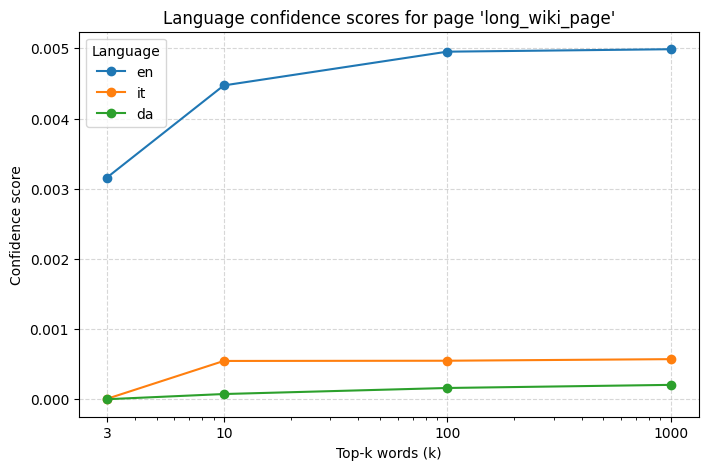

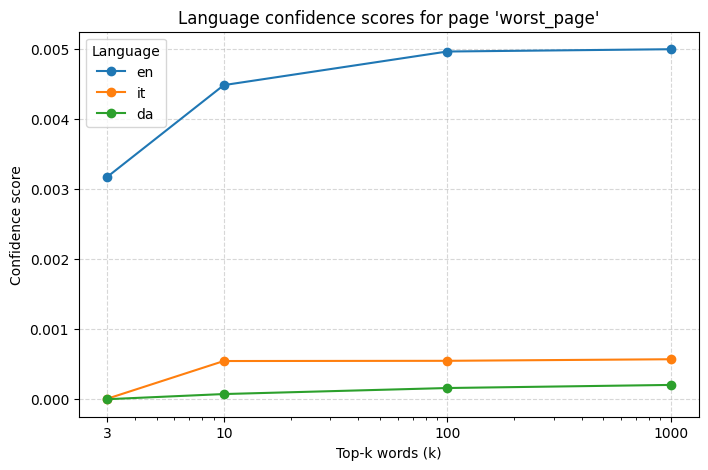

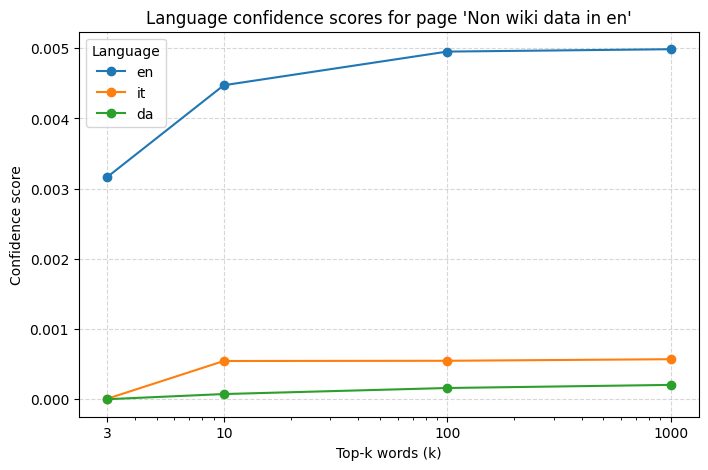

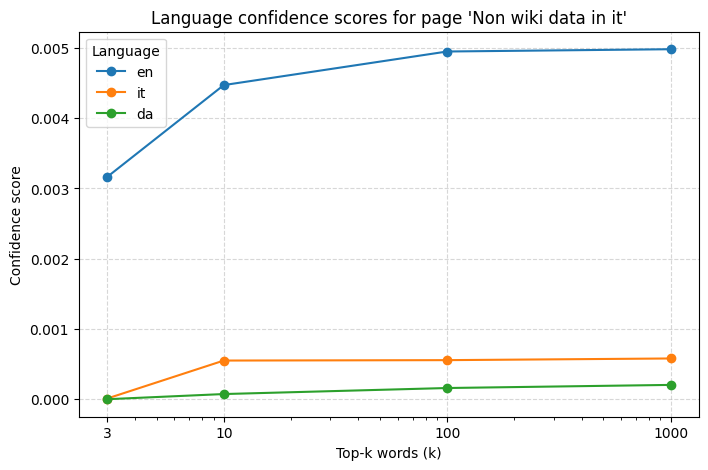

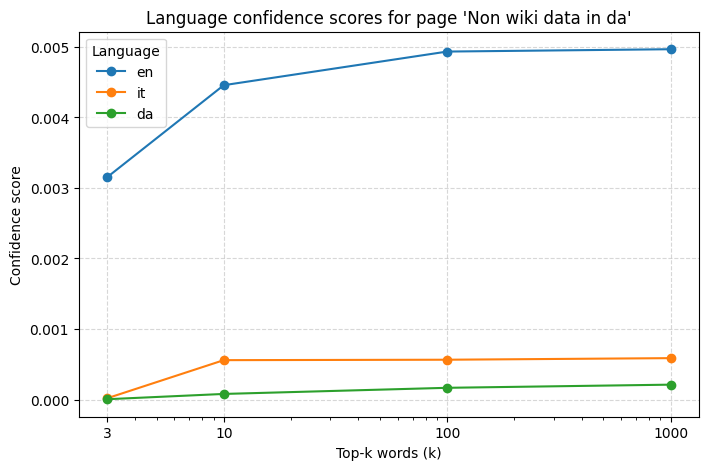

In [38]:
scores_data = compute_scores_table(pages, lang_refs)

plot_scores(scores_data)